## Importing libraries and defining structure of neural network model.

[50, 125, 200]


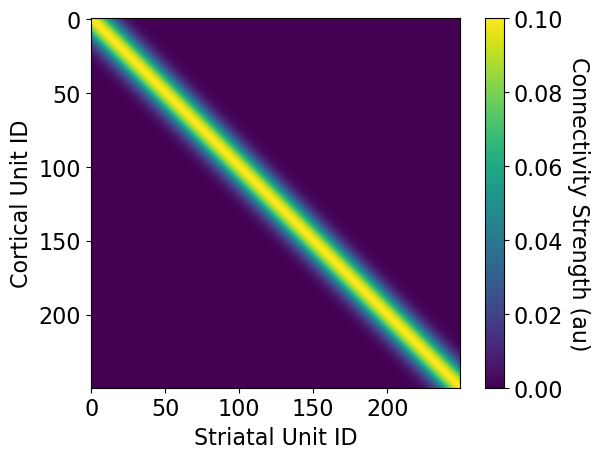

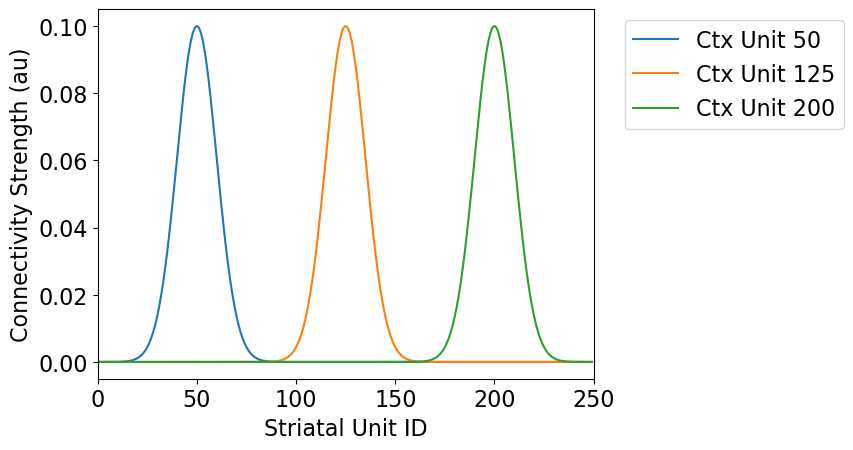

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


class b_ganglia:
    def __init__(self,n_loops,time_steps,exc_spread = 15):

        self.n_loops = n_loops
        self.n_steps = time_steps
        
        initial_activity = 0.1
        #activations for all units and matrix to hold input
        self.a_sd1 = np.zeros((time_steps, n_loops))+initial_activity
        self.in_sd1 = np.zeros((time_steps, n_loops))
        self.a_sd2 = np.zeros((time_steps, n_loops))+initial_activity
        self.in_sd2 = np.zeros((time_steps, n_loops))
        self.a_stn = np.zeros((time_steps, n_loops))+initial_activity
        self.in_stn = np.zeros((time_steps, n_loops))
        self.a_gpi = np.ones((time_steps, n_loops))+initial_activity
        self.in_gpi = np.ones((time_steps, n_loops))
        self.a_gpe = np.zeros((time_steps, n_loops))+initial_activity
        self.a_tha = np.zeros((time_steps, n_loops))+initial_activity
        self.a_ctx = np.zeros((time_steps, n_loops))+initial_activity
        self.in_ctx = np.zeros((time_steps, n_loops))
        self.in_tha = np.zeros((time_steps, n_loops))

        #vector to hold changing dopamine levels
        self.da = np.ones((time_steps))

        #vector to hold the inputs...
        self.a_input = np.zeros((time_steps, n_loops))


        #variable to keep track of what step we are currently on
        self.c = 0

        #### weights connecting all the layers #####

        #cortico-striatal connections are topographical, but also overlapping, thus we will use the Guassians we have previously shown work
        #first change from the original version, we will not have "input"-striatum connections, we will have a single cortical layer at the top receiving both "input" and thalamic input

        #initializing the matrices to hold all the weights
        self.w_ctx_sd1 = np.zeros((n_loops,n_loops))
        self.w_ctx_sd2 = np.zeros((n_loops,n_loops))


        #the weights from input to the cortex will just be the identity matrix I think
        ####self.w_inp_ctx = np.identity(n_loops)# * 0.32


        self.unit_ids = np.arange(0,n_loops,1) 

        w_ctx_sd = 1
        
        for i in range(0,n_loops):
            #inserting the Guassians into the matrix
            #wider-spreading connectivities
            self.w_ctx_sd1[i] = stats.norm.pdf(self.unit_ids, i, exc_spread) / np.max(stats.norm.pdf(self.unit_ids, i, exc_spread)) *w_ctx_sd/exc_spread #the dividing by the max ensure the weight distribution has a max of 1 before any other changes, just keeps the weights reasonable I think
            self.w_ctx_sd2[i] = stats.norm.pdf(self.unit_ids, i, exc_spread) / np.max(stats.norm.pdf(self.unit_ids, i, exc_spread)) *w_ctx_sd/exc_spread

        self.sd1_bias = -.2
        self.sd2_bias = -.2
        
        #second attempt at this, implementing pure 1-to-1 connectivity
        self.w_ctx_stn = np.identity(n_loops) * 2.5
        self.stn_bias = 0
        
        self.w_sd1_gpi = np.identity(n_loops) * -3
        self.gpi_bias = .4
        
        self.w_sd2_gpe = np.identity(n_loops) * -3#
        self.gpe_bias = .4
        
        self.w_gpe_stn = np.identity(n_loops) * -1
        self.w_gpe_gpi = np.identity(n_loops) * -0.1 
        
        self.w_gpi_tha = np.identity(n_loops) * -2 
        self.tha_bias = .6
        
        self.w_tha_ctx = np.identity(n_loops) * 3 
        self.ctx_bias = -.2
        
        #the STN has dense connectivity to the output nuclei so we can just set these as an array of ones
        self.w_stn_gpi = np.ones((self.n_loops,self.n_loops)) * 0.1
        self.w_stn_gpe = np.ones((self.n_loops,self.n_loops)) * 0.1


    #uses euler integration to calculate the activation at each unit in the model of the basal ganglia 
    def run(self, input,dop_level, input_noise_level = 0, da_noise = 0, RAS = 'None', RAS_spread = 4, RAS_strength = 1, tempo_switch = 0, ran_seed=None, clock_noise = 0):
        
        #likely easier to just define the parameters inside this function...
        dt = 0.001
        tau = 0.005
        #time constant 
        h= dt/tau
        
        self.a_input = input + input_noise_level * np.random.normal(size = (len(input), self.n_loops))/np.sqrt(dt) 
        self.da_noise = da_noise
        if ran_seed != None:
            np.random.seed(seed=ran_seed)

        ras_timings = np.zeros(len(input))

        #adding RAS pulses to input train...
        if RAS != 'None':
            next_ras = RAS
        
            while next_ras < len(self.a_input):
                if tempo_switch != 0 and next_ras >= 6000:
                    self.a_input[next_ras:next_ras+100] += RAS_strength * (stats.norm.pdf(self.unit_ids, self.tempo_to_index(RAS), RAS_spread) / np.max(stats.norm.pdf(self.unit_ids, self.tempo_to_index(RAS), RAS_spread)))
                    RAS = RAS + tempo_switch
                    tempo_switch = 0
                    ras_timings[next_ras] = 1
                    next_ras += RAS
                else:
                    self.a_input[next_ras:next_ras+100] += RAS_strength * (stats.norm.pdf(self.unit_ids, self.tempo_to_index(RAS), RAS_spread) / np.max(stats.norm.pdf(self.unit_ids, self.tempo_to_index(RAS), RAS_spread)))
                    ras_timings[next_ras] = 1
                    next_ras += RAS


        
        #define the sensitivies to dopamine and normal response
        sd1_bl = 0.3
        sd1_DA = 0.75
        sd2_bl = .5
        sd2_DA = 4

        #network dopamine throughout simulation
        self.da = np.ones(len(self.a_input))

        #vector to hold whether or not a tap is produced each step...
        self.tapout = np.zeros(len(self.a_input))

        #vector to hold how close the participant is to tapping, decays with rate set by the currently selected tempo
        self.tap_proximity = np.zeros(len(self.a_input))
        self.tap_proximity[0] = 1
    
        noise = np.zeros(self.n_steps)
        
        self.tempo_report = np.zeros(self.n_steps-1)

        #eulers method
        for i in range(self.n_steps - 1):

            self.in_ctx[i+1] = np.matmul(self.a_tha[i], self.w_tha_ctx) +self.ctx_bias
            self.a_ctx[i+1] = self.a_ctx[i] + h * (self.non_lin(self.in_ctx[i+1] ) - self.a_ctx[i])

#            input_noise = np.random.normal(size = self.n_loops) * (self.input_noise_level)/np.sqrt(dt) 
            
            sd1_mult = (sd1_bl + sd1_DA * self.da[i])
            self.in_sd1[i+1] = sd1_mult * np.matmul(self.a_ctx[i] , self.w_ctx_sd1) +self.sd1_bias +  self.a_input[i]
            self.a_sd1[i+1] = self.a_sd1[i] + h * (self.non_lin(self.in_sd1[i+1] ) - self.a_sd1[i])
            
            sd2_mult = (1/(sd2_bl + sd2_DA * self.da[i]))
            self.in_sd2[i+1] = sd2_mult * np.matmul(self.a_ctx[i], self.w_ctx_sd2) +self.sd2_bias + self.a_input[i]
            self.a_sd2[i+1] = self.a_sd2[i] + h * (self.non_lin(self.in_sd2[i+1] ) - self.a_sd2[i])

            self.in_stn[i+1] = np.matmul(self.a_ctx[i], self.w_ctx_stn) + np.matmul(self.a_gpe[i], self.w_gpe_stn) +self.stn_bias + self.a_input[i]
            self.a_stn[i+1] = self.a_stn[i] + h * (self.non_lin(self.in_stn[i+1] ) - self.a_stn[i])
            
            self.a_gpe[i+1] = self.a_gpe[i] + h * (self.non_lin(np.matmul(self.a_sd2[i], self.w_sd2_gpe) + np.matmul(self.a_stn[i], self.w_stn_gpe) + self.gpe_bias ) - self.a_gpe[i])
            
            self.in_gpi[i+1] = np.matmul(self.a_sd1[i], self.w_sd1_gpi) + np.matmul(self.a_stn[i], self.w_stn_gpi) + np.matmul(self.a_gpe[i], self.w_gpe_gpi)  + self.gpi_bias
            self.a_gpi[i+1] = self.a_gpi[i] + h * (self.non_lin(self.in_gpi[i+1] ) - self.a_gpi[i]) 
            
            self.in_tha[i+1] = np.matmul(self.a_gpi[i], self.w_gpi_tha)  + self.tha_bias
            self.a_tha[i+1] = self.a_tha[i] + h * (self.non_lin(self.in_tha[i+1] ) - self.a_tha[i]) 
            
            #update dopamine, will tend to approach dop_level or hover around it
            self.da[i+1] = self.da[i] + (dop_level[i] - self.da[i])*dt*1 + np.random.normal()*np.sqrt(dt)*self.da_noise
            
            #record the most salient tempo for the current step
            self.tempo_report[i] = self.index_to_tempo(np.sum((self.unit_ids ) * self.a_tha[i]) / np.sum(self.a_tha[i]))
            noise[i] = np.random.normal() * clock_noise 
            self.tap_proximity[i+1] = self.tap_proximity[i] - dt * 1000/self.tempo_report[i] + noise[i]* np.sqrt(dt)
 
            if self.tap_proximity[i+1] < 0:
                self.tap_proximity[i+1] = 1
                self.tapout[i] = 1

        tap_indices = [i for i in range(len(self.tapout)) if self.tapout[i]==1]
        ras_indices = [i for i in range(len(ras_timings)) if ras_timings[i]==1]
        self.ITI_report = np.diff(tap_indices)*dt*1000
        self.ISI_report = np.diff(ras_indices)*dt*1000


        return None

    #non-linearity to generate activations
    def non_lin(self,vec):

        #apply non-linearity
        x = np.tanh(vec)
        
        #set any negative values to 0
        for i in range(self.n_loops):
            if x[i] < 0:
                x[i] = 0
        
        return x


    def tempo_to_index(self,tempo):
        return int((np.log(tempo) - 5.8)/1.3*self.n_loops)

    def index_to_tempo(self,index):
        return np.exp(index *1.3/ self.n_loops + 5.8)

    def full_display(self):

        titles = ('Ctx', 'SD1', 'SD2', "STN", "GPi/SNpr", "GPe", "Tha")
        data = (self.a_ctx, self.a_sd1, self.a_sd2, self.a_stn, self.a_gpi, self.a_gpe, self.a_tha)

        fig, ax = plt.subplots(7)
        fig.set_figheight(20)
        fig.set_figwidth(15)
        fig.tight_layout()

        for i in range(0,7):
            im = ax[i].imshow(data[i][2000:70000].T,aspect='auto')
            ax[i].set_title(str(titles[i]+ ' layer activations'), fontsize=28)
            cbar = plt.colorbar(im, ax=ax[i])
            
            if i != 6:
                ax[i].set_xticklabels([])
            ax[i].tick_params(axis="x", labelsize=28)
            ax[i].tick_params(axis="y", labelsize=24) 
            ax[3].set_ylabel("Unit IDs", fontsize=32)
            ax[6].set_xlabel("Time Step", fontsize=32)
            cbar.ax.tick_params(labelsize=24) 
            
        plt.figure(2)
        plt.figure(figsize=(15, 3)) 
        plt.plot(self.da[2000:], c='#2C7BB6')
        plt.title("Dopamine levels", fontsize=28)
        plt.xticks([])
        plt.yticks(fontsize=24)


        plt.figure(3)
        plt.figure(figsize=(15, 3)) 
        plt.plot(self.tempo_report[2000:], c='#2C7BB6')
        plt.title("Encoded Tempo", fontsize=28)
        plt.xticks(fontsize=24, rotation=45)
        plt.yticks(fontsize=24)
        plt.ylabel("Tempo (ms)",fontsize=24)
        plt.ylim([600,700])
        plt.xlabel("Time Steps",fontsize=32)

        plt.figure(4)
        plt.plot(self.tempo_report[2000:], color='#2C7BB6', linewidth=2)
        plt.xlabel('Time step',fontsize="32")
        plt.ylabel('Tempo', fontsize="32")
        plt.ylim((550,750))
        plt.xticks(fontsize="24",rotation=45)
        plt.yticks([550, 600,650,700,750], fontsize="24")
    
        plt.show

    def condensed_display(self):

        titles = ('Input','Ctx', 'SD1', "GPi/SNpr", "Tha")
        data = (self.a_input,self.a_ctx, self.a_sd1, self.a_gpi, self.a_tha)

        fig, ax = plt.subplots(5)
        fig.set_figheight(14.25)
        fig.set_figwidth(15)
        fig.tight_layout()

        for i in range(0,5):
            if i == 0:
                im = ax[i].imshow(data[i][2000:70000].T,aspect='auto',vmin=0, vmax=1)
            else:
                im = ax[i].imshow(data[i][2000:70000].T,aspect='auto')
            ax[i].set_title(str(titles[i]+ ' layer activations'), fontsize=28)
            cbar = plt.colorbar(im, ax=ax[i])
            
            if i != 4:
                ax[i].set_xticklabels([])
            ax[i].tick_params(axis="x", labelsize=28)
            ax[i].tick_params(axis="y", labelsize=24) 
            ax[2].set_ylabel("Unit IDs", fontsize=32)
            ax[4].set_xlabel("Time (ms)", fontsize=32)
            cbar.ax.tick_params(labelsize=24) 
            
        plt.figure(2)
        plt.figure(figsize=(15, 3)) 
        plt.plot(self.da[2000:], c='#2C7BB6')
        plt.title("Dopamine levels", fontsize=28)
        plt.ylim([0.5,0.9])
        plt.xlim([0, len(self.da[2000:])])
        plt.xticks([])
        plt.yticks(fontsize=24)
        


        plt.figure(5)
        plt.plot(self.tempo_report[2000:], color='#2C7BB6')
        plt.xlabel('Time step',fontsize="32")
        plt.ylabel('Tempo', fontsize="32")
        plt.ylim((550,750))
        plt.xticks(fontsize="24",rotation=45)
        plt.yticks(fontsize="24")
    
        plt.show

    def mini_display(self):

        titles = ('Input', "Tha")
        data = (self.a_input,self.a_ctx, self.a_sd1, self.a_gpi, self.a_tha)

        fig, ax = plt.subplots(3)
        fig.set_figheight(6)
        fig.set_figwidth(15)
        fig.tight_layout()

        for i in range(0,2):
            im = ax[i].imshow(data[i][:70000].T,aspect='auto')
            ax[i].set_title(str(titles[i]+ ' layer activations'), fontsize=28)
            
            if i != 1:
                ax[i].set_xticklabels([])
            ax[i].tick_params(axis="x", labelsize=28)
            ax[i].tick_params(axis="y", labelsize=24) 


        ax[1].set_ylabel("Unit IDs", fontsize=32)

        
        ax[2].plot(self.tempo_report[:70000], color='#2C7BB6')
        ax[2].tick_params(axis="x", labelsize=28)
        ax[2].tick_params(axis="y", labelsize=24) 
        ax[2].set_xlim([0,len(self.tempo_report[:70000])])
        
        plt.ylim((550,750))
    
        plt.show

    def full_demo(self):

        titles = ('Input','Ctx', 'SD1', 'SD2', "STN", "GPi/SNpr", "GPe", "Tha")
        data = (self.a_input, self.a_ctx, self.a_sd1, self.a_sd2, self.a_stn, self.a_gpi, self.a_gpe, self.a_tha)

        fig, ax = plt.subplots(8)
        fig.set_figheight(20)
        fig.set_figwidth(15)
        fig.tight_layout()

        for i in range(0,8):
            if i == 0:
                im = ax[i].imshow(data[i][0:70000].T,aspect='auto',vmin=0, vmax=1)
            else:
                im = ax[i].imshow(data[i][0:70000].T,aspect='auto')
            ax[i].set_title(str(titles[i]+ ' layer activations'), fontsize=28)
            cbar = plt.colorbar(im, ax=ax[i])
            cbar.ax.tick_params(labelsize=24)
            
            if i != 7:
                ax[i].set_xticklabels([])
                ax[i].tick_params(axis="x", labelsize=28)
                ax[i].tick_params(axis="y", labelsize=24) 
                ax[4].set_ylabel("Unit IDs", fontsize=32)
                ax[7].set_xlabel("Time Step (ms)", fontsize=32)
                ax[7].tick_params(axis="y", labelsize=24) 
            
        plt.figure(2)
        plt.figure(figsize=(15, 3)) 
        plt.plot(self.da, c='#2C7BB6')
        plt.title("Dopamine levels", fontsize=28)
        plt.xticks([])
        plt.yticks(fontsize=24)


        plt.figure(3)
        plt.figure(figsize=(15, 3)) 
        plt.plot(self.tempo_report, c='#2C7BB6')
        plt.title("Instantaneous Action Tempo", fontsize=28)
        plt.xticks(fontsize=24, rotation=45)
        plt.yticks([600,640,680],['600','640','680'],fontsize=24)
        plt.ylabel("Period (ms)",fontsize=24)
        plt.ylim([600,700])
        plt.xlim([0,len(self.tempo_report)])
        plt.xlabel("Time  (ms)",fontsize=32)
        
        plt.show

n_loops=250 #number of "loops" in network, equivalent to number of units in each layer.
start_tempo=650 #defines which tempo the network initially selects, in other words, controls where the "start-up" pulse of cortex layer excitation is given.
input_spread = 2 #controls the width of the above mentioned "start-up" pulse
input = np.zeros((5000, n_loops)) #defines the external input to the cortical layer, control the length of the simulation by altering the length of this variable.

bg1 = b_ganglia(n_loops=n_loops, time_steps=len(input), exc_spread = 10) #initilizes the network
plt.figure(1)
plt.imshow(bg1.w_ctx_sd1)
plt.xlabel('Striatal Unit ID', fontsize=16)
plt.ylabel('Cortical Unit ID', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = plt.colorbar()
cbar.set_label('Connectivity Strength (au)', rotation=270, fontsize = 16, labelpad=20)
cbar.ax.tick_params(labelsize=16)

plt.figure(2)
ids = [50,125,200] #np.arange(0,250,25)
print(ids)
for i in ids:
    plt.plot(bg1.w_ctx_sd1[i,:],label = "Ctx Unit "+str(i))
plt.xlim([0,250])
plt.xlabel("Striatal Unit ID", fontsize =16)
plt.ylabel("Connectivity Strength (au)", fontsize =16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16,bbox_to_anchor=(1.04, 1), loc="upper left")


# Fig 2a General Attractor Behavior

130


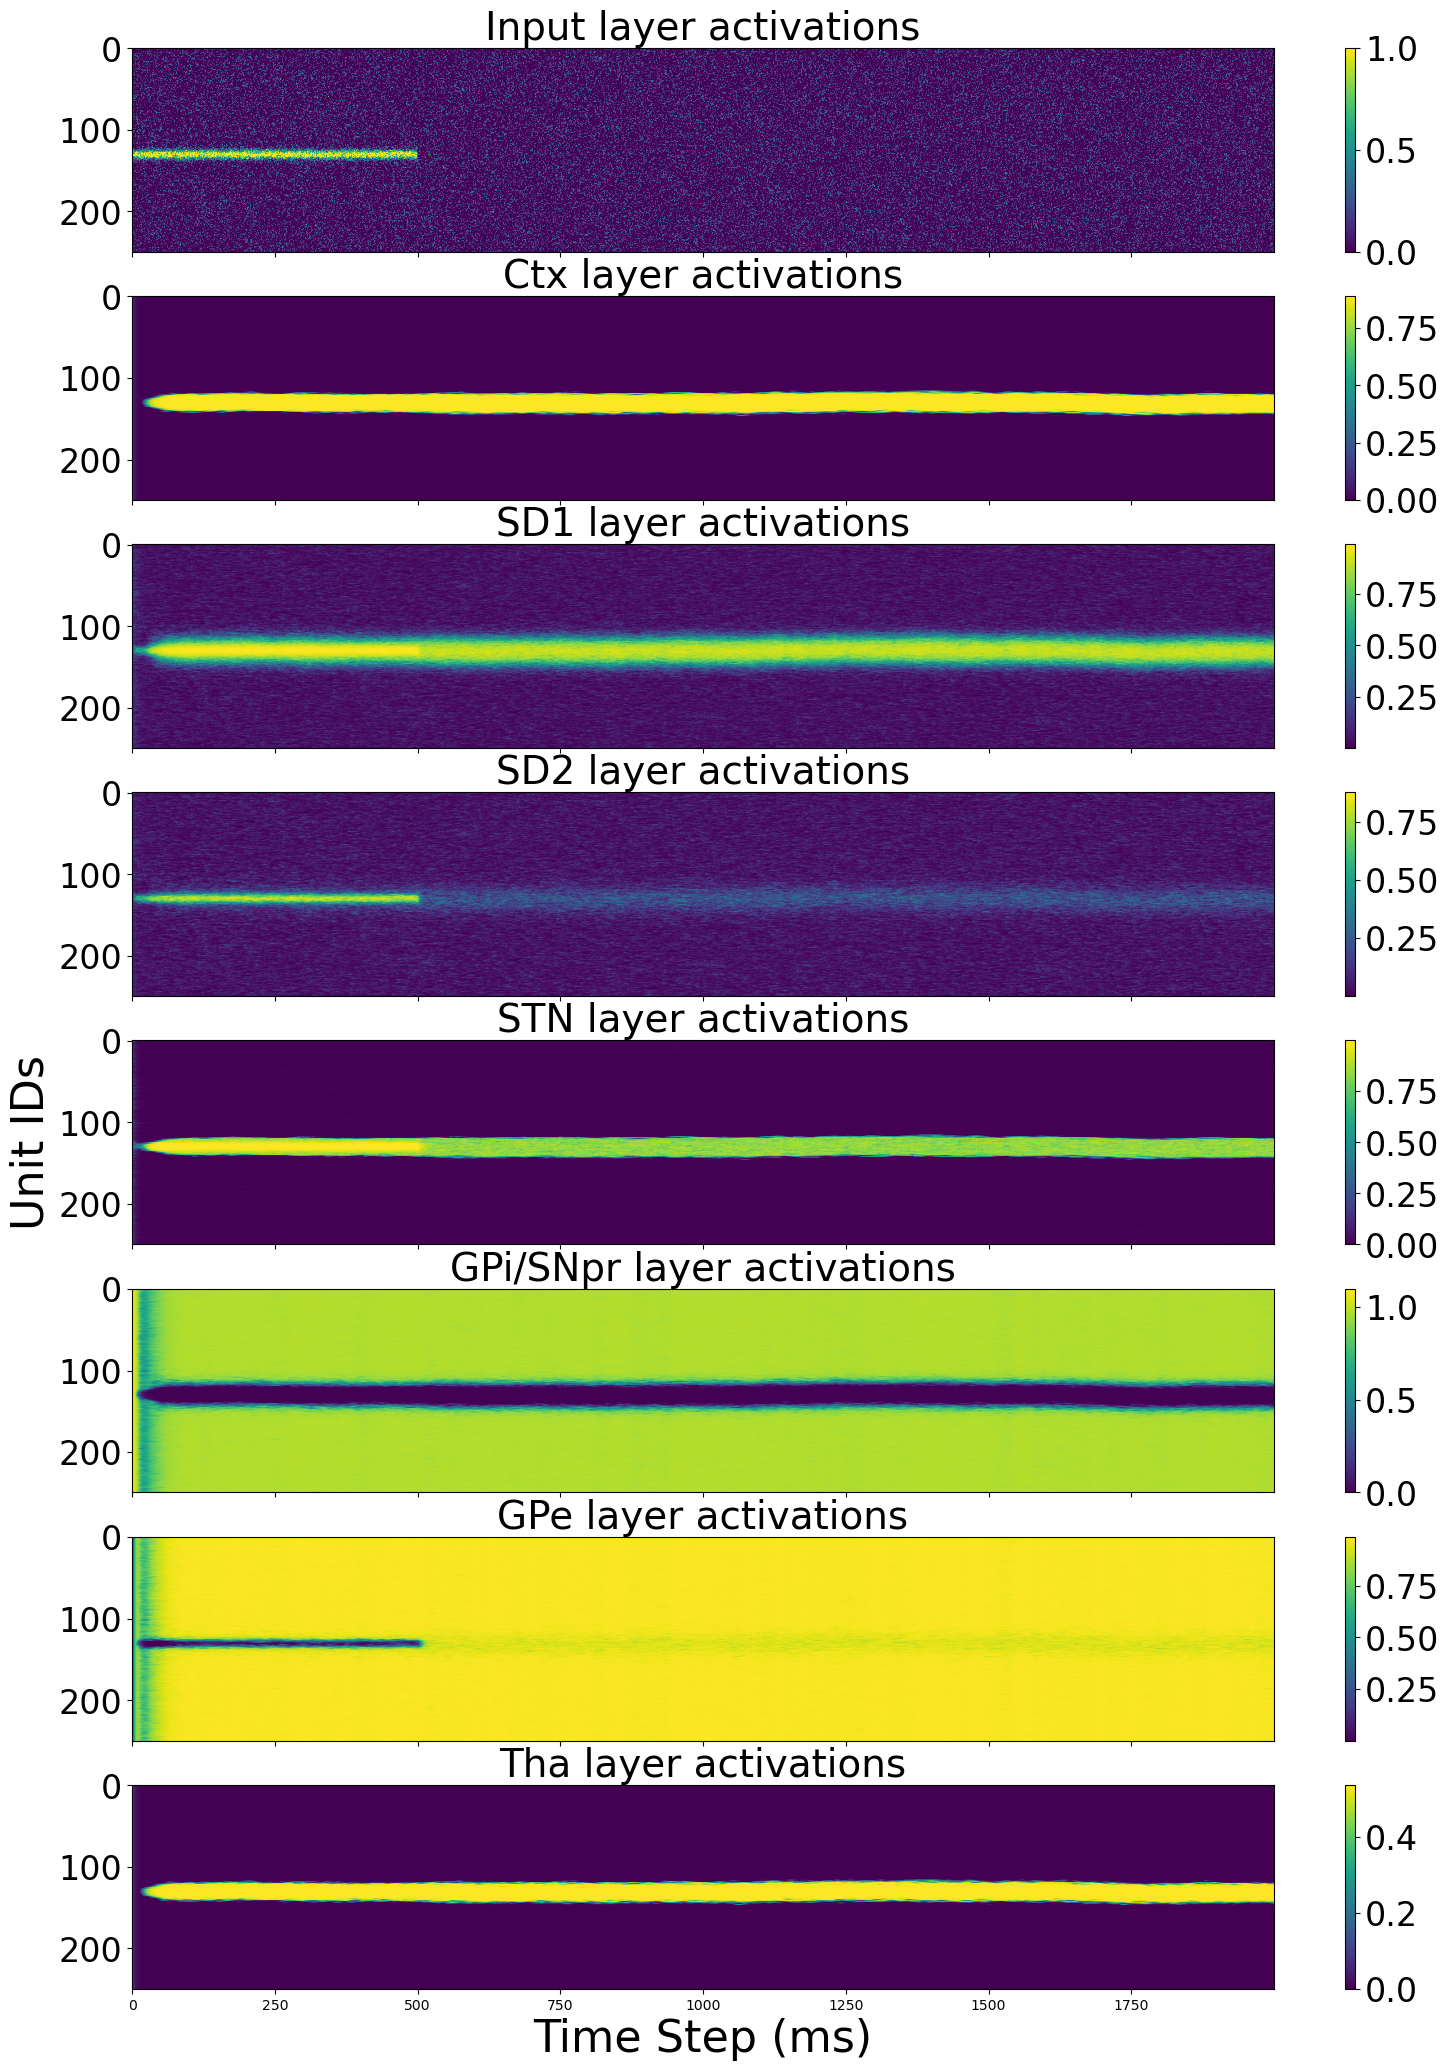

<Figure size 640x480 with 0 Axes>

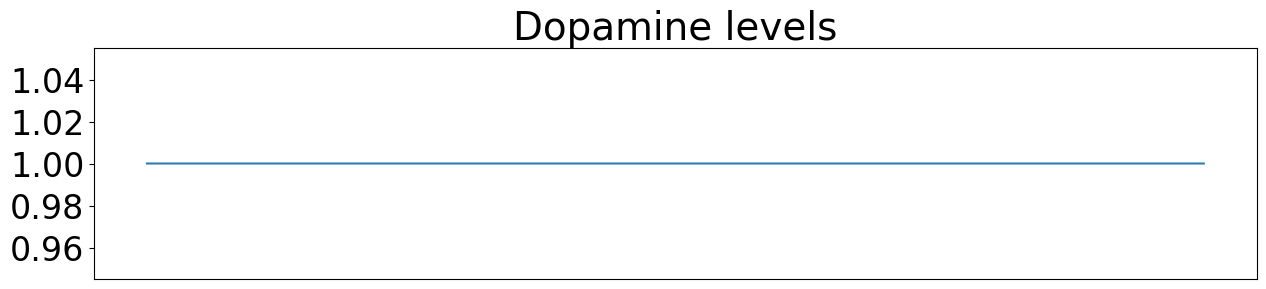

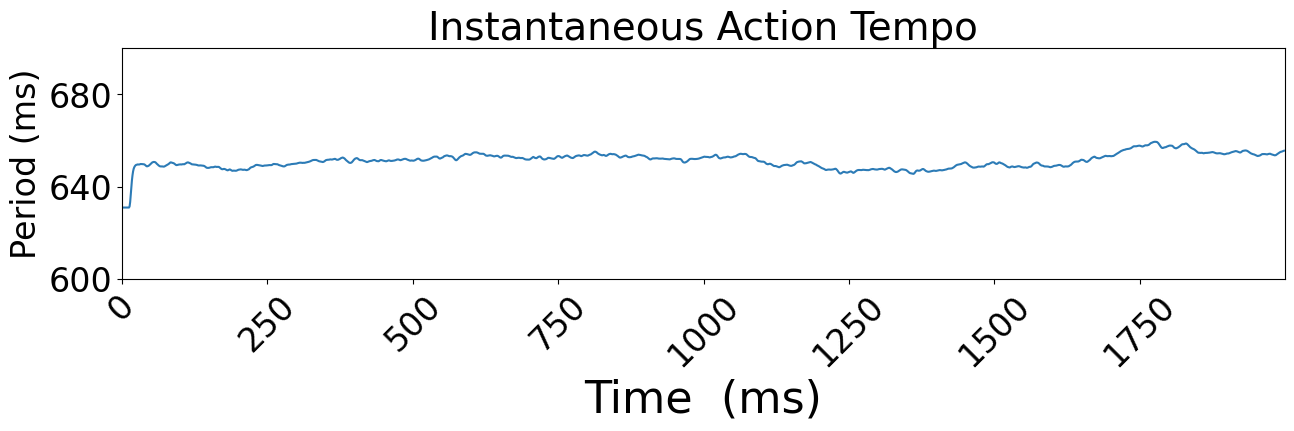

In [3]:
n_loops=250 #number of "loops" in network, equivalent to number of units in each layer.
start_tempo=650 #defines which tempo the network initially selects, in other words, controls where the "start-up" pulse of cortex layer excitation is given.
input_spread = 4 #controls the width of the above mentioned "start-up" pulse
input = np.zeros((2000, n_loops)) #defines the external input to the cortical layer, control the length of the simulation by altering the length of this variable.

bg1 = b_ganglia(n_loops=n_loops, time_steps=len(input), exc_spread = 10) #initilizes the network

#creates the intial pulse of cortical excitation in the input variable.
input[0:500] = (stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread) / np.max(stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread)))
print(bg1.tempo_to_index(start_tempo))
#run the simulation
bg1.run(input,dop_level=np.ones(len(input)), da_noise = 0, input_noise_level = .01, ran_seed = 1)

#plot the results.
bg1.full_demo()

# Fig 2b Maintenance of Different Tempos

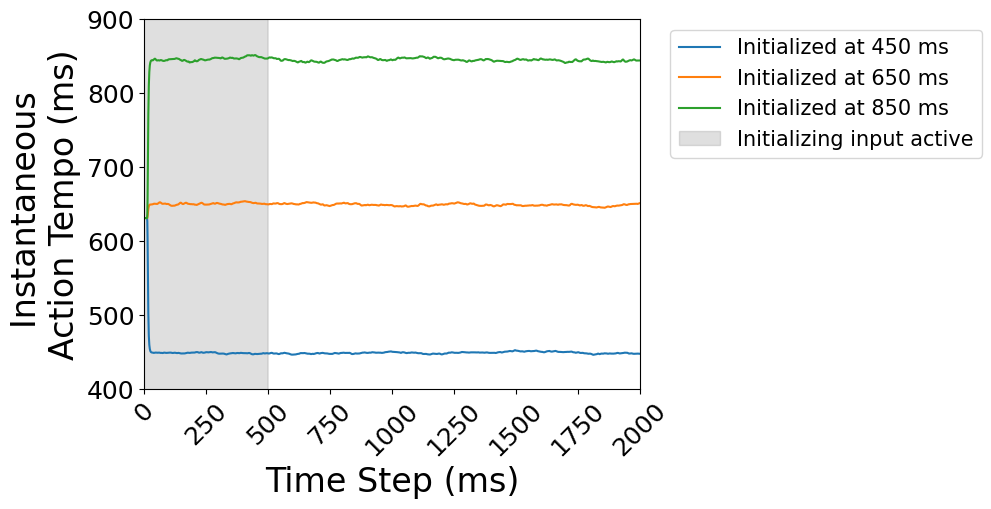

In [6]:
n_loops=250 #for notes on intializing the network see code for Figure 2a.
start_tempo=650
input_spread = 4
input = np.zeros((2001, n_loops))

#create array to store the results. 
tempo_store = np.zeros((3,2000))

bg1 = b_ganglia(n_loops=n_loops, time_steps=len(input), exc_spread = 10)
start_tempos = [450, 650, 850] #array of different tempos to be simulated.

#simulate at each intial tempo and store the results.
for i in range(3):
    input[0:2000] = (stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempos[i]), input_spread) / np.max(stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempos[i]), input_spread)))
    bg1.run(input,dop_level=np.ones(len(input)), da_noise = 0, input_noise_level = .01, ran_seed=12345678)
    tempo_store[i,:] = bg1.tempo_report

#plot the results.
plt.plot(tempo_store[0,:],label=("Initialized at 450 ms"))
plt.plot(tempo_store[1,:],label=("Initialized at 650 ms"))
plt.plot(tempo_store[2,:],label=("Initialized at 850 ms"))
plt.fill_betweenx(np.arange(0,2000), 0, 500, color='grey', alpha=0.25, label='Initializing input active')
plt.ylabel("Instantaneous \nAction Tempo (ms)", fontsize = 24)
plt.xlabel("Time Step (ms)", fontsize = 24)
plt.yticks(fontsize=18)
plt.xticks(rotation=45,fontsize=18)
plt.ylim((400,900))
plt.xlim((0,len(tempo_store[0,:])))
plt.legend(fontsize=15,bbox_to_anchor=(1.04, 1), loc="upper left")

# Fig 2c Progressive Loss of Dopamine

Text(0.5, 0, 'Time Step (ms)')

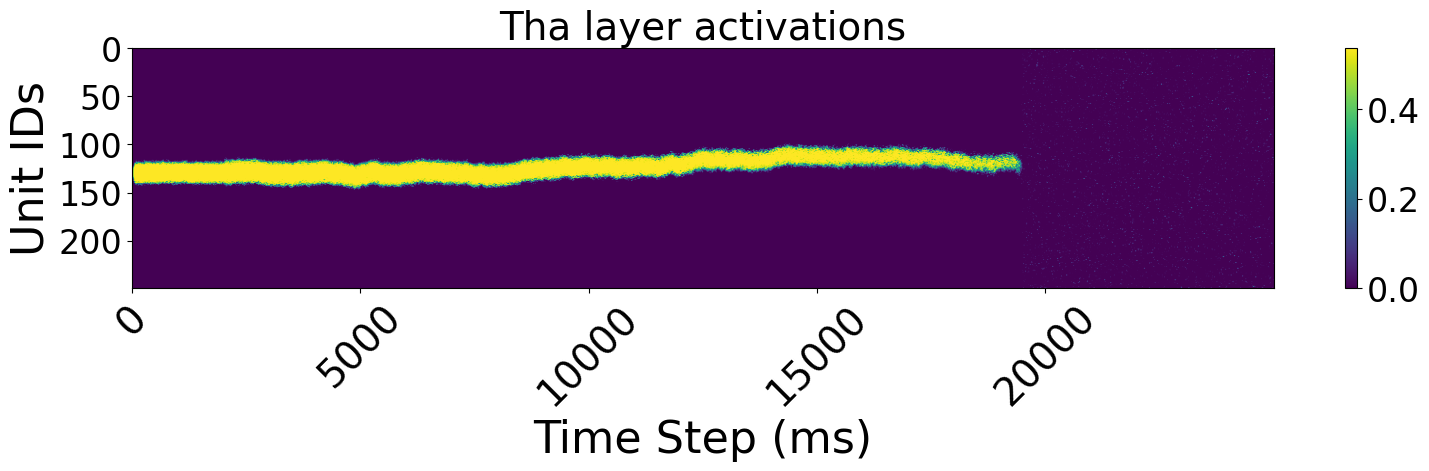

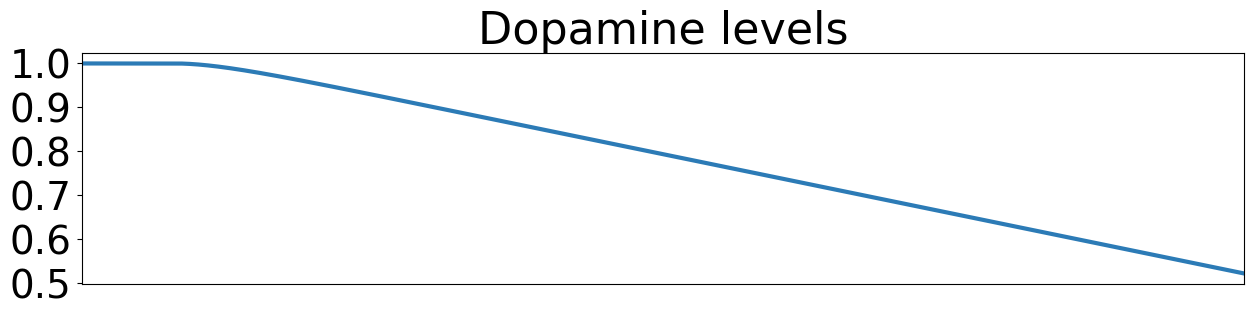

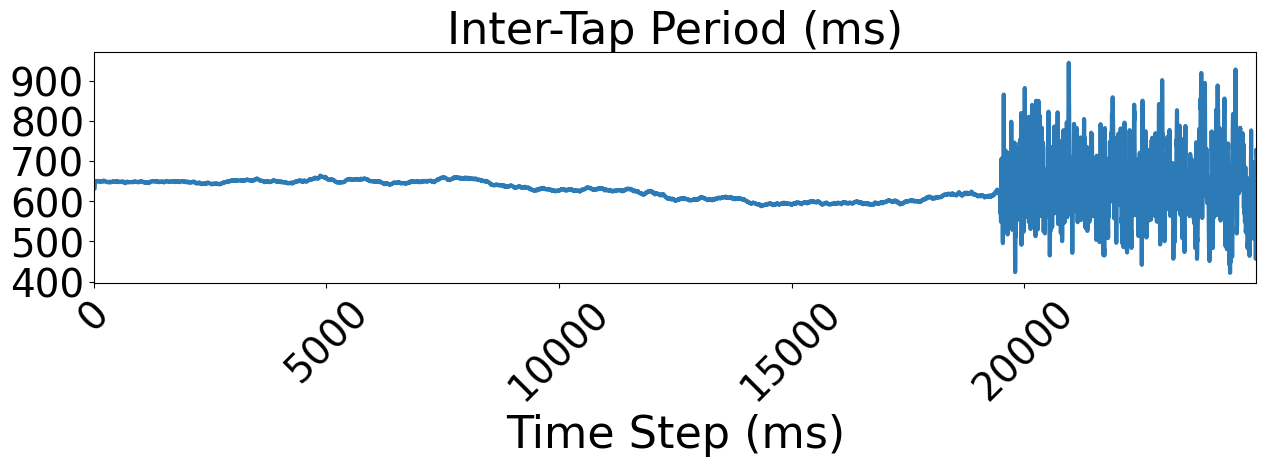

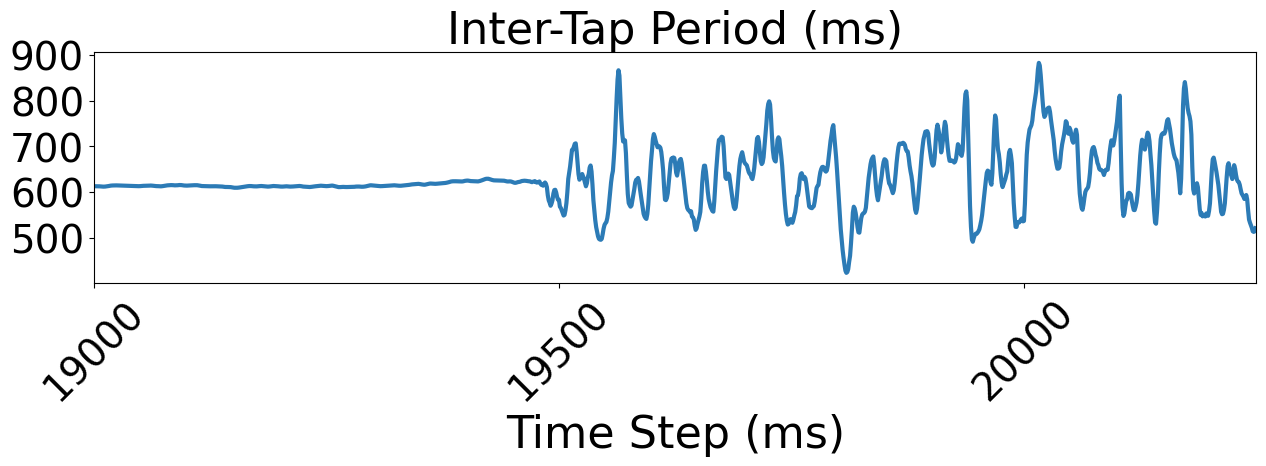

In [88]:
n_loops=250 #for notes on intializing the network see code for Figure 2a.
start_tempo=650
input_spread = 4
input = np.zeros((25000, n_loops))

bg1 = b_ganglia(n_loops=n_loops, time_steps=len(input), exc_spread = 10)

input[0:2000] = (stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread) / np.max(stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread)))

#create array of dopamine values that decreases across the length of the simulation. 
step_wise = np.ones(25000)
step_wise[2000:25000] = np.linspace(1,0.5,23000)


bg1.run(input,dop_level=step_wise, da_noise = 0, input_noise_level = .01, ran_seed=123)

#plotting the results, want it to be consisted with other figures. 
fig, ax = plt.subplots(1)
fig.set_figheight(3)
fig.set_figwidth(15)
fig.tight_layout()

plt.imshow(bg1.a_tha[:].T, aspect="auto")
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24)
plt.title( 'Tha layer activations', fontsize=28)
plt.xticks(fontsize=28,rotation=45)
plt.yticks(fontsize=24)
plt.ylabel("Unit IDs", fontsize=32)
plt.xlabel("Time Step (ms)", fontsize=32)
        
plt.figure(figsize=(15, 3)) 

plt.plot(bg1.da[:], c='#2C7BB6',linewidth=3)
plt.title("Dopamine levels", fontsize=32)
plt.xticks([])
plt.yticks(fontsize=28)
plt.xlim([0,len(bg1.da[:])])

plt.figure(figsize=(15, 3))
plt.plot(bg1.tempo_report, c='#2C7BB6',linewidth=3)
plt.title("Inter-Tap Period (ms)", fontsize=32)
plt.xticks(fontsize=28,rotation=45)
plt.yticks(fontsize=28)
plt.xlim([0,len(bg1.tempo_report)])
plt.xlabel("Time Step (ms)", fontsize=32)

plt.figure(figsize=(15, 3))
plt.plot(bg1.tempo_report[19000:20250], c='#2C7BB6',linewidth=3)
plt.title("Inter-Tap Period (ms)", fontsize=32)
plt.xticks([0,500,1000], ['19000','19500', '20000'],fontsize=28,rotation=45)
plt.yticks(fontsize=28)
plt.xlim([0,len(bg1.tempo_report[19000:20250])])
plt.xlabel("Time Step (ms)", fontsize=32)



# Fig3a Effect of Low Dopamine on Tempo Trace

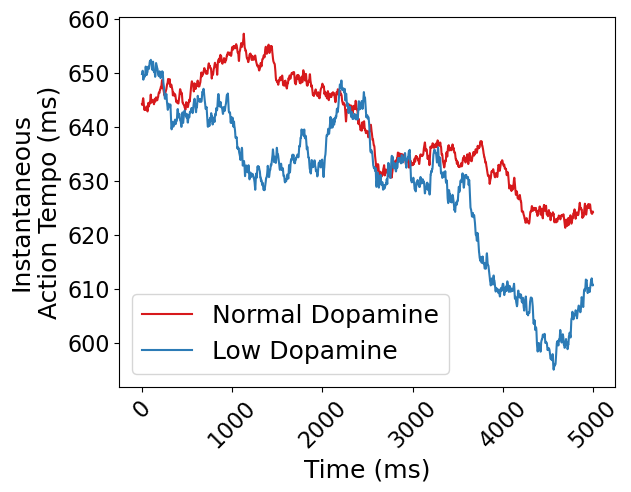

In [4]:
n_loops=250 #for notes on intializing the network see code for Figure 2a.
start_tempo=650
input_spread = 4
input = np.zeros((7000, n_loops))

input[0:2000] = (stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread) / np.max(stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread)))

#intialize and run a network with RAS
bg1 = b_ganglia(n_loops=n_loops, time_steps=len(input), exc_spread = 10)
bg1.run(input,dop_level=np.ones(len(input)), da_noise = 0, input_noise_level = 0.01, ran_seed=1234568)

#intialize and run a network without RAS
bg2 = b_ganglia(n_loops=n_loops, time_steps=len(input), exc_spread = 10)
bg2.run(input,dop_level=np.ones(len(input)) * 0.7, da_noise = 0, input_noise_level = .01, ran_seed=1234568)

plt.figure()
plt.plot(bg1.tempo_report[2000:],label = 'Normal Dopamine', c='#D7191C')
plt.plot(bg2.tempo_report[2000:], label = 'Low Dopamine', c='#2C7BB6')

plt.ylabel("Instantaneous\nAction Tempo (ms)", fontsize=18)
plt.xlabel("Time (ms)", fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16,rotation=45)

plt.legend(fontsize=18)

# Fig 3b Simulated "Parkinson's" Noise Breakdown

In [47]:
n_loops=250 #intialize and run a network with RAS
start_tempo=650
input_spread = 4
input = np.zeros((50000, n_loops))
n_trials = 100 #define the number of trials to be simulated

bg1 = b_ganglia(n_loops=n_loops, time_steps=len(input), exc_spread = 10)

input[0:2000] = (stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread) / np.max(stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread)))

normal_ITIS = np.zeros((n_trials, 60)) #define arrays to hold the produced inter-tap intervals from our simulations
parkinson_ITIS = np.zeros((n_trials, 60))
RAS_ITIS= np.zeros((n_trials, 60))

for i in range(n_trials):
    bg1.run(input,dop_level=np.ones(len(input)), da_noise = 0, input_noise_level = .01, clock_noise = 0.05)
    normal_ITIS[i,:] = bg1.ITI_report[0:60]
    print("Completed simulation " + str(i))

#import experimental data
import pickle
ITI_data = {'AMC_ITIs': normal_ITIS}
f = open("ITI_data_8_normal.pkl", "wb")
pickle.dump(ITI_data, f)
f.close()



Completed simulation 0
Completed simulation 1
Completed simulation 2
Completed simulation 3
Completed simulation 4
Completed simulation 5
Completed simulation 6
Completed simulation 7
Completed simulation 8
Completed simulation 9
Completed simulation 10
Completed simulation 11
Completed simulation 12
Completed simulation 13
Completed simulation 14
Completed simulation 15
Completed simulation 16
Completed simulation 17
Completed simulation 18
Completed simulation 19
Completed simulation 20
Completed simulation 21
Completed simulation 22
Completed simulation 23
Completed simulation 24
Completed simulation 25
Completed simulation 26
Completed simulation 27
Completed simulation 28
Completed simulation 29
Completed simulation 30
Completed simulation 31
Completed simulation 32
Completed simulation 33
Completed simulation 34
Completed simulation 35
Completed simulation 36
Completed simulation 37
Completed simulation 38
Completed simulation 39
Completed simulation 40
Completed simulation 41
Co

In [48]:

for i in range(n_trials):
    bg1.run(input,dop_level=np.ones(len(input))*0.7, da_noise = 0, input_noise_level = .01, clock_noise = 0.05)
    parkinson_ITIS[i,:] = bg1.ITI_report[0:60]
    print(i)

import pickle
ITI_data = {'PD_ITIs': parkinson_ITIS, 'AMC_ITIs': normal_ITIS}
f = open("ITI_data_8_normal_PD.pkl", "wb")
pickle.dump(ITI_data, f)
f.close()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [49]:
np.size(bg1.ITI_report)

76

In [50]:


for i in range(n_trials):
    bg1.run(input,dop_level=np.ones(len(input))*0.7, RAS = 650, da_noise = 0, input_noise_level = .01, clock_noise = 0.05)
    RAS_ITIS[i,:] = bg1.ITI_report[0:60]
    print(i)

import pickle
ITI_data = {'PD_ITIs': parkinson_ITIS, 'AMC_ITIs': normal_ITIS, 'RAS_ITIs': RAS_ITIS}
f = open("ITI_data_8_all.pkl", "wb")
pickle.dump(ITI_data, f)
f.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [51]:
#ITI_data = pickle.load(open("ITI_data_8_all.pkl", "rb"))

#just checking mean values before plotting
parkinson_ITIS = ITI_data['PD_ITIs']
normal_ITIS = ITI_data['AMC_ITIs']
RAS_ITIS = ITI_data['RAS_ITIs']
nRAS_ITIS = parkinson_ITIS
print(np.mean(normal_ITIS))
print(np.mean(parkinson_ITIS))

652.3083333333333
657.3236666666667


In [52]:
#create arrays to hold variance breakdowns for each trial type.
normal_var = np.zeros(n_trials)
normal_clock = np.zeros(n_trials)
normal_motor = np.zeros(n_trials)
normal_drift = np.zeros(n_trials)

parkinsons_var = np.zeros(n_trials)
parkinsons_clock = np.zeros(n_trials)
parkinsons_motor = np.zeros(n_trials)
parkinsons_drift = np.zeros(n_trials)

#for each trial calculate the amount of clock, motor, and drift variance as described in paper.
for i in range(n_trials):
    ITIs  = normal_ITIS[i,:]
    n_taps = len(ITIs)

    s0 = (1/(n_taps-1)) * np.sum((ITIs - np.mean(ITIs))**2)

    s1 = (1/(2*(n_taps-1))) * np.sum(np.diff(ITIs)**2)

    s2 = (1/(2*(n_taps-2))) * (np.sum((ITIs[2:] - ITIs[0:-2])**2))

    #store variance breakdowns
    normal_var[i] = s0
    normal_clock[i] = 3*s2 - 2*s1
    normal_motor[i] = s1-s2
    normal_drift[i] = s0 - 2*s1/n_taps - s2*(n_taps-1)/n_taps

#do the same thing for the low dopamine trials.
for i in range(n_trials):
    ITIs  = parkinson_ITIS[i,:]
    n_taps = len(ITIs)

    s0 = (1/(n_taps-1)) * np.sum((ITIs - np.mean(ITIs))**2)

    s1 = (1/(2*(n_taps-1))) * np.sum(np.diff(ITIs)**2)

    s2 = (1/(2*(n_taps-2))) * (np.sum((ITIs[2:] - ITIs[0:-2])**2))

    parkinsons_var[i] = s0
    parkinsons_clock[i] = 3*s2 - 2*s1
    parkinsons_motor[i] = s1-s2
    parkinsons_drift[i] = s0 - 2*s1/n_taps - s2*(n_taps-1)/n_taps

print(np.mean(normal_var))
print(np.mean(parkinsons_var))

1040.2736666666667
1513.9271129943504


In [68]:
#plot variance breakdowns for low dopamine vs normal dopamine trial types
data_a = [normal_clock, normal_motor, normal_drift]
data_b = [parkinsons_clock, parkinsons_motor, parkinsons_drift]

ticks = ['Clock variance', 'Motor variance', 'Drift variance']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


plt.figure(figsize=(2,4))

bpl = plt.boxplot(normal_var, positions=[-.4], sym='', widths=0.6)
bpr = plt.boxplot(parkinsons_var, positions=[0.4], sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

plt.plot([], c='#D7191C', label='Normal')
plt.plot([], c='#2C7BB6', label='Parkinsons')
#plt.legend(loc = 'upper center')

plt.xticks([0],['ITI variance'])
plt.ylim(0, 5500)
plt.ylabel(r'$ms^2$')
plt.tight_layout()
plt.savefig('sim_varcompare_data.png')

plt.figure(figsize=(5,4))

bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Normal dopamine')
plt.plot([], c='#2C7BB6', label='Low dopamine')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-1, len(ticks)*2-1)
plt.ylim(-800, 2700)
plt.ylabel(r'$ms^2$')
#plt.ylim(0, 8)
plt.tight_layout()
plt.savefig('sim_subvarcompare_data.png')

#calculate p-values for comparisons
results = stats.mannwhitneyu(normal_var,parkinsons_var)
print('Total variance: p = ' + str(results[1]))

results = stats.mannwhitneyu(normal_clock,parkinsons_clock)
print('Clock variance: p = ' + str(results[1]))

results = stats.mannwhitneyu(normal_motor,parkinsons_motor)
print('Motor variance: p = ' + str(results[1]))

results = stats.mannwhitneyu(normal_drift,parkinsons_drift)
print('Drift variance: p = ' + str(results[1]))
print(np.shape(parkinson_ITIS))




NameError: name 'normal_clock' is not defined

In [54]:
normal_motor

array([ -12.70119813,   60.01534191,  -17.27147867, -131.5808007 ,
        -44.30143191,   99.74196376, -272.02235535,   49.09848042,
       -202.07130333, -295.20718878,  187.10739334,  -91.77688486,
         -1.95689655,   10.42343659, -161.75336061,  139.7619813 ,
        189.64859731, -250.67665108, -117.99181765, -154.05260082,
       -339.7893045 ,  -35.51548802,   17.04514904, -217.35461718,
         42.94696084,  -17.90970193,   -7.45558153,  112.30391584,
       -280.43541788, -300.08591467,  -59.24386324,  138.09774985,
        -18.39465225, -100.04427236,   18.15312683,  -59.60169492,
         25.00131502,  -67.32218001, -266.6157218 , -255.83386908,
        -39.5654588 ,  -86.34380479,  -41.35534775,  251.96171829,
         14.27717709,  -15.3056692 ,   91.39815897,  118.94929866,
       -183.48480421, -162.7106955 ,  -45.38033314,  329.78185272,
        -67.67387493,   74.76841029,   27.39392168, -154.73611923,
        -54.8733197 ,   24.03974284,  122.64012274, -100.31604

# Fig 3c Noise Breakdown for Experimental Data

In [ ]:
#load in experimental dataset
import pandas as pd

df = pd.read_csv('all_PD_AHC_data.csv')
PD_ids = (df.Group == 2);
PD_ids_excl = (df.Group == 2) * (df.Group == 2) * (df.avg_slope<.001)
AHC_ids = (df.Group == 3);

df

Participant  Group     Xcorr  mean_IOIs_ba_1  mean_IOIs_ba_2  Slopes_ba_1  \
0            40      1  0.403979        0.465183        0.412100    -0.001077   
1            45      1  0.390288        0.675882        0.673887    -0.001617   
2            39      1  0.648191        0.661909        0.686260    -0.000100   
3            51      2  0.525798        0.544933        0.505583     0.000403   
4            65      2  0.286918        0.330667        0.350967     0.000065   
..          ...    ...       ...             ...             ...          ...   
87           74      2  0.498791        0.396067        0.392750     0.001379   
88            1      3  0.490434        0.535610        0.534050    -0.000063   
89           42      1  0.547767        0.561833        0.545450    -0.000412   
90           30      1  0.634566        0.667109        0.660346     0.000137   
91           31      1  0.642551        0.846568        0.856083    -0.000051   

    Slopes_ba_2  avg_slope  ntaps_ba_1  ntaps_ba_2  ...  d_drift_2  \
0     -0.000505  -0.000791          60          60  ...   0.000110   
1     -0.000637  -0.001127          51          53  ...   0.000007   
2      0.000317   0.000109          55          50  ...   0.000105   
3      0.000644   0.000523          60          60  ...  -0.000109   
4     -0.000005   0.000030          60          60  ...   0.000069   
..          ...        ...         ...         ...  ...        ...   
87     0.000643   0.001011          60          40  ...   0.000009   
88    -0.000306  -0.000184          59          60  ...  -0.000052   
89    -0.000597  -0.000505          60          60  ...  -0.000072   
90     0.000546   0.000341          55          52  ...  -0.000012   
91     0.001669   0.000809          44          48  ...   0.000545   

    d_avg_motor  d_avg_clock  d_avg_drift  avg_motor_weber  avg_clock_weber  \
0      0.000237     0.000819     0.000054         0.034964         0.045443   
1      0.000272     0.000740    -0.000055         0.024233         0.039510   
2     -0.000093     0.000627     0.000095         0.000000         0.036783   
3      0.001031    -0.000260     0.000813         0.041868         0.024955   
4      0.000272    -0.000061     0.000064         0.047904         0.000000   
..          ...          ...          ...              ...              ...   
87     0.000479     0.005741     0.000013         0.043395         0.192363   
88    -0.000081     0.000875    -0.000066         0.000000         0.054548   
89    -0.000045     0.000649    -0.000069         0.000000         0.046020   
90    -0.000099     0.000615    -0.000061         0.000000         0.036778   
91    -0.000374     0.003340     0.000188         0.000000         0.067542   

    avg_drift_weber  d_avg_motor_weber  d_avg_clock_weber  d_avg_drift_weber  
0          0.036642           0.035126           0.045299           0.012711  
1          0.023317           0.024280           0.039392           0.001907  
2          0.015302           0.000000           0.036803           0.014454  
3          0.043012           0.041818           0.024969           0.038226  
4          0.023598           0.047906           0.000000           0.023470  
..              ...                ...                ...                ...  
87         0.040277           0.043410           0.192112           0.009073  
88         0.000000           0.000000           0.054568           0.000000  
89         0.005620           0.000000           0.046007           0.000000  
90         0.005692           0.000000           0.036776           0.000000  
91         0.019240           0.000000           0.067483           0.013639  

[92 rows x 37 columns]

p = 0.007016880334424392


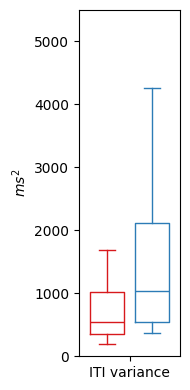

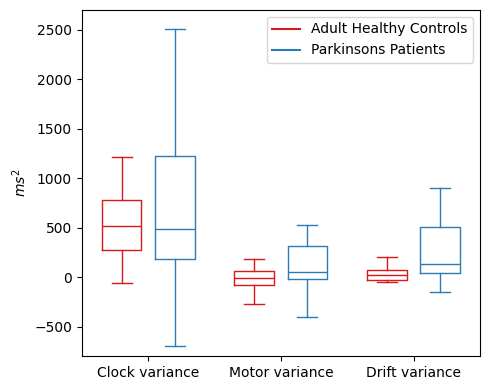

In [150]:


exp_data_a = [df[AHC_ids].avg_clock* 1000000 , df[AHC_ids].avg_motor* 1000000, df[AHC_ids].avg_drift* 1000000]
exp_data_b = [df[PD_ids].avg_clock* 1000000, df[PD_ids].avg_motor* 1000000, df[PD_ids].avg_drift* 1000000]

ticks = ['Clock variance', 'Motor variance', 'Drift variance']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


plt.figure(figsize=(2,4))

bpl = plt.boxplot(df[AHC_ids].avg_STD**2 * 1000000, positions=[-.4], sym='', widths=0.6)
bpr = plt.boxplot(df[PD_ids].avg_STD**2 * 1000000, positions=[0.4], sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

plt.plot([], c='#D7191C', label='Normal')
plt.plot([], c='#2C7BB6', label='Parkinsons')
#plt.legend(loc='upper center')

plt.xticks([0],['ITI variance'])
plt.ylim(0, 5500)
plt.ylabel(r'$ms^2$')
plt.tight_layout()
plt.savefig('exp_varcompare_data.png')


plt.figure(figsize=(5,4))

bpl = plt.boxplot(exp_data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(exp_data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Adult Healthy Controls')
plt.plot([], c='#2C7BB6', label='Parkinsons Patients')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-1, len(ticks)*2-1)
plt.ylim(-800, 2700)
plt.ylabel(r'$ms^2$')
#plt.ylim(0, 8)
plt.tight_layout()
plt.savefig('exp_subvarcompare_data.png')

results = stats.mannwhitneyu(df[AHC_ids].avg_STD**2,df[PD_ids].avg_STD**2)
print('p = ' + str(results[1]))


# Fig 4a Demo of Freezing

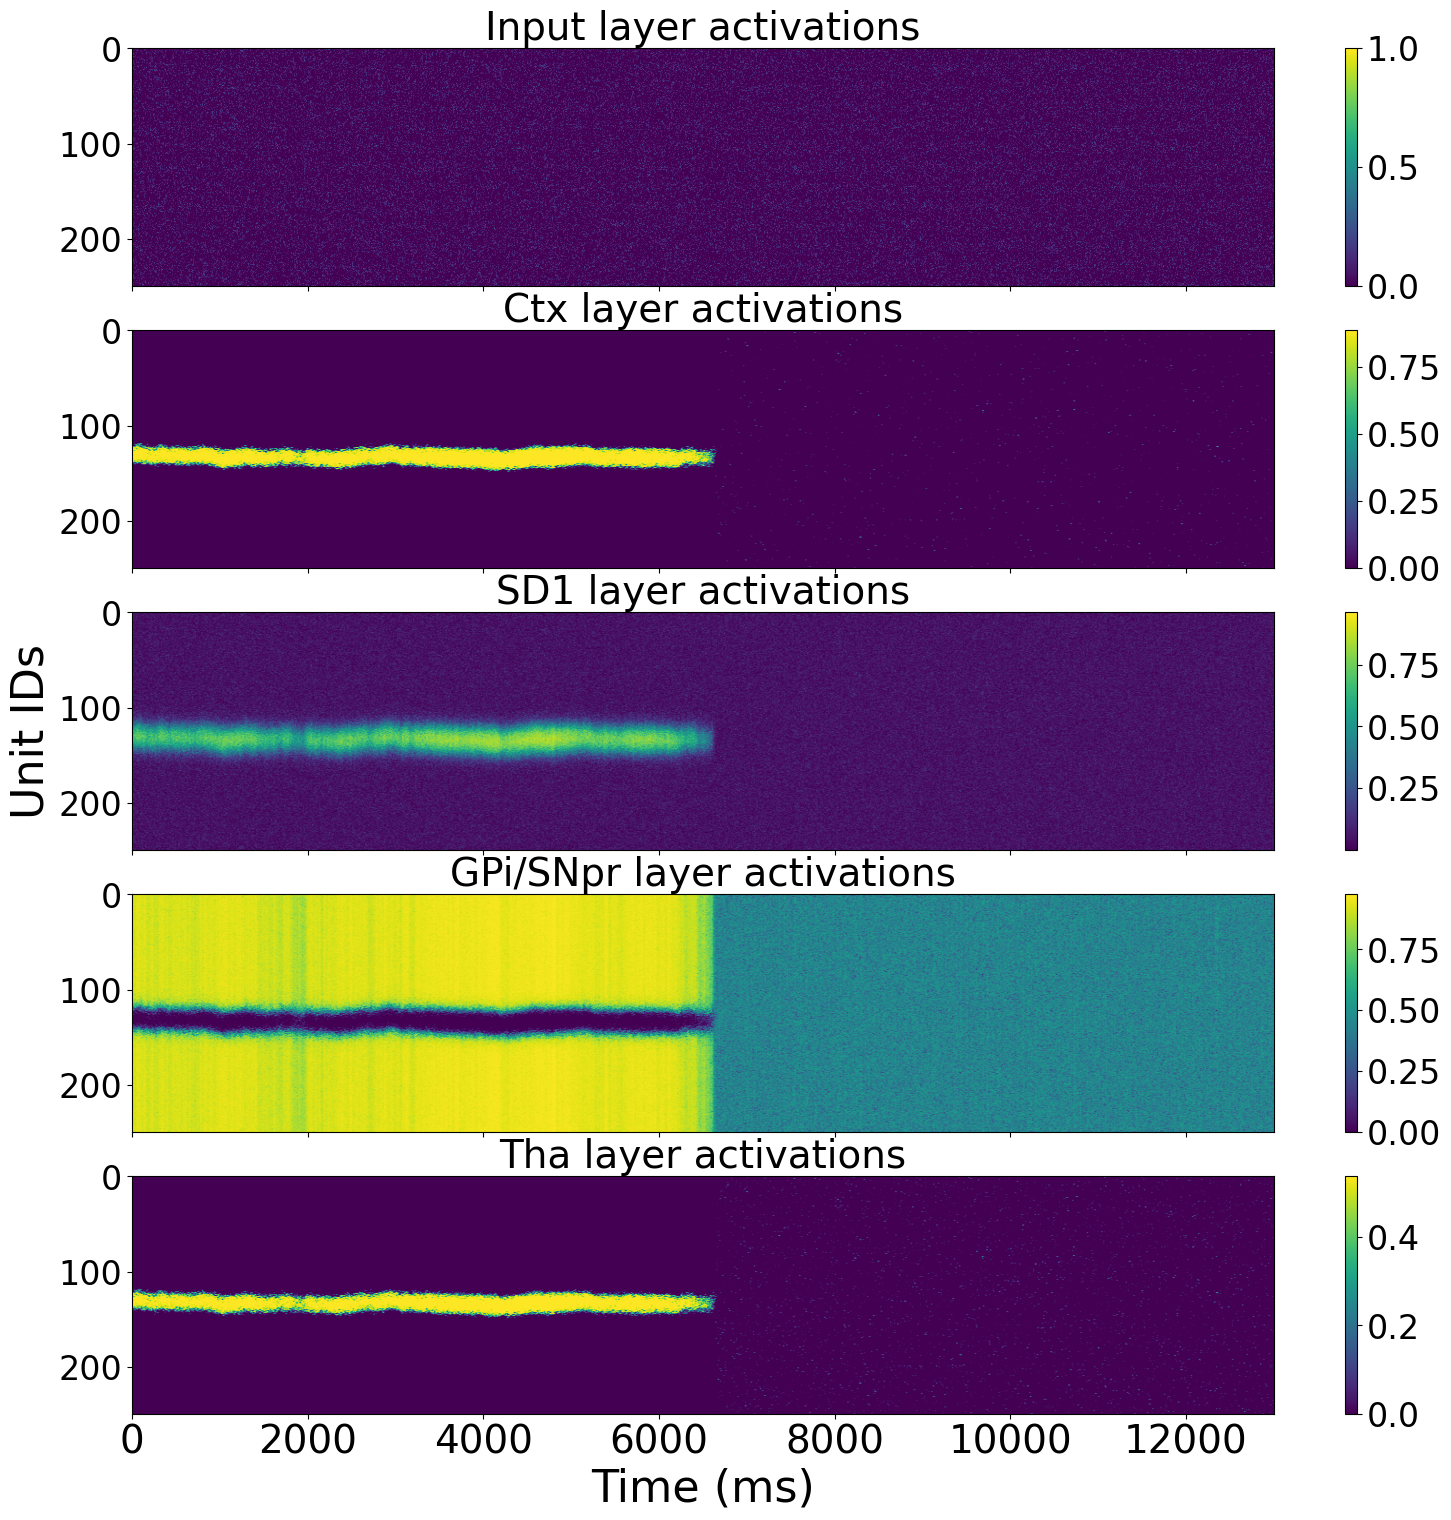

<Figure size 640x480 with 0 Axes>

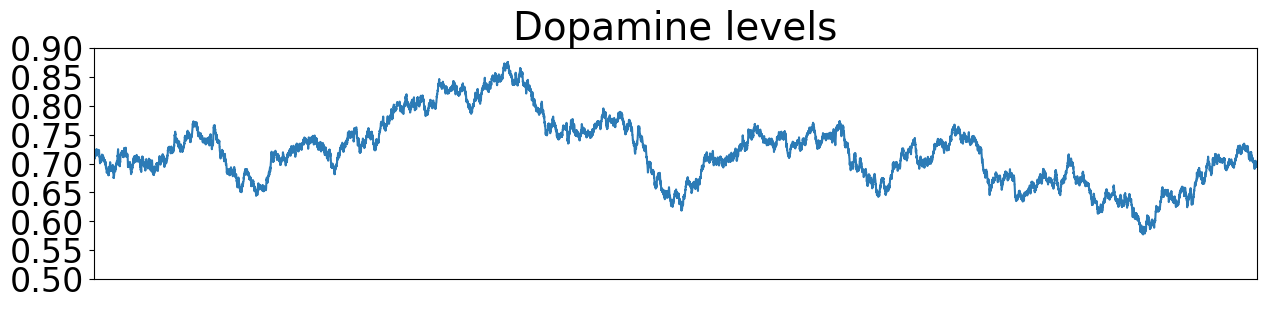

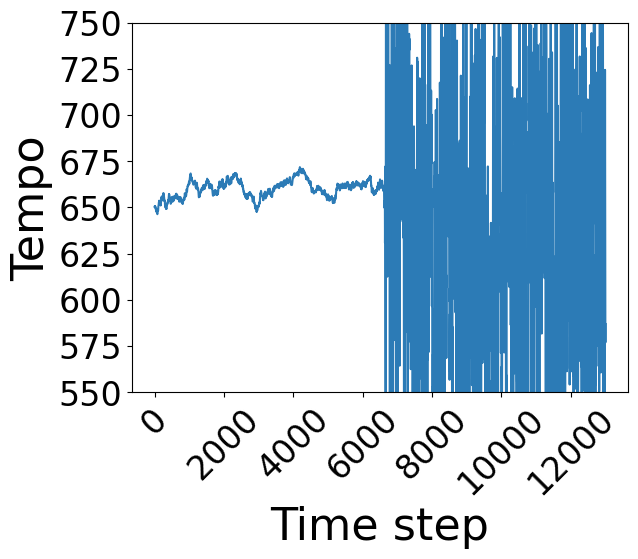

In [12]:
n_loops=250
start_tempo=650
input_spread = 4
input = np.zeros((15000, n_loops))

bg1 = b_ganglia(n_loops=n_loops, time_steps=len(input), exc_spread = 10)

input[0:2000] = (stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread) / np.max(stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread)))

bg1.run(input,dop_level=np.ones(len(input))*0.7, da_noise = 0.075, input_noise_level = .01, ran_seed=12345678)

bg1.condensed_display()

# Fig 4b Prevention of Freezing with RAS

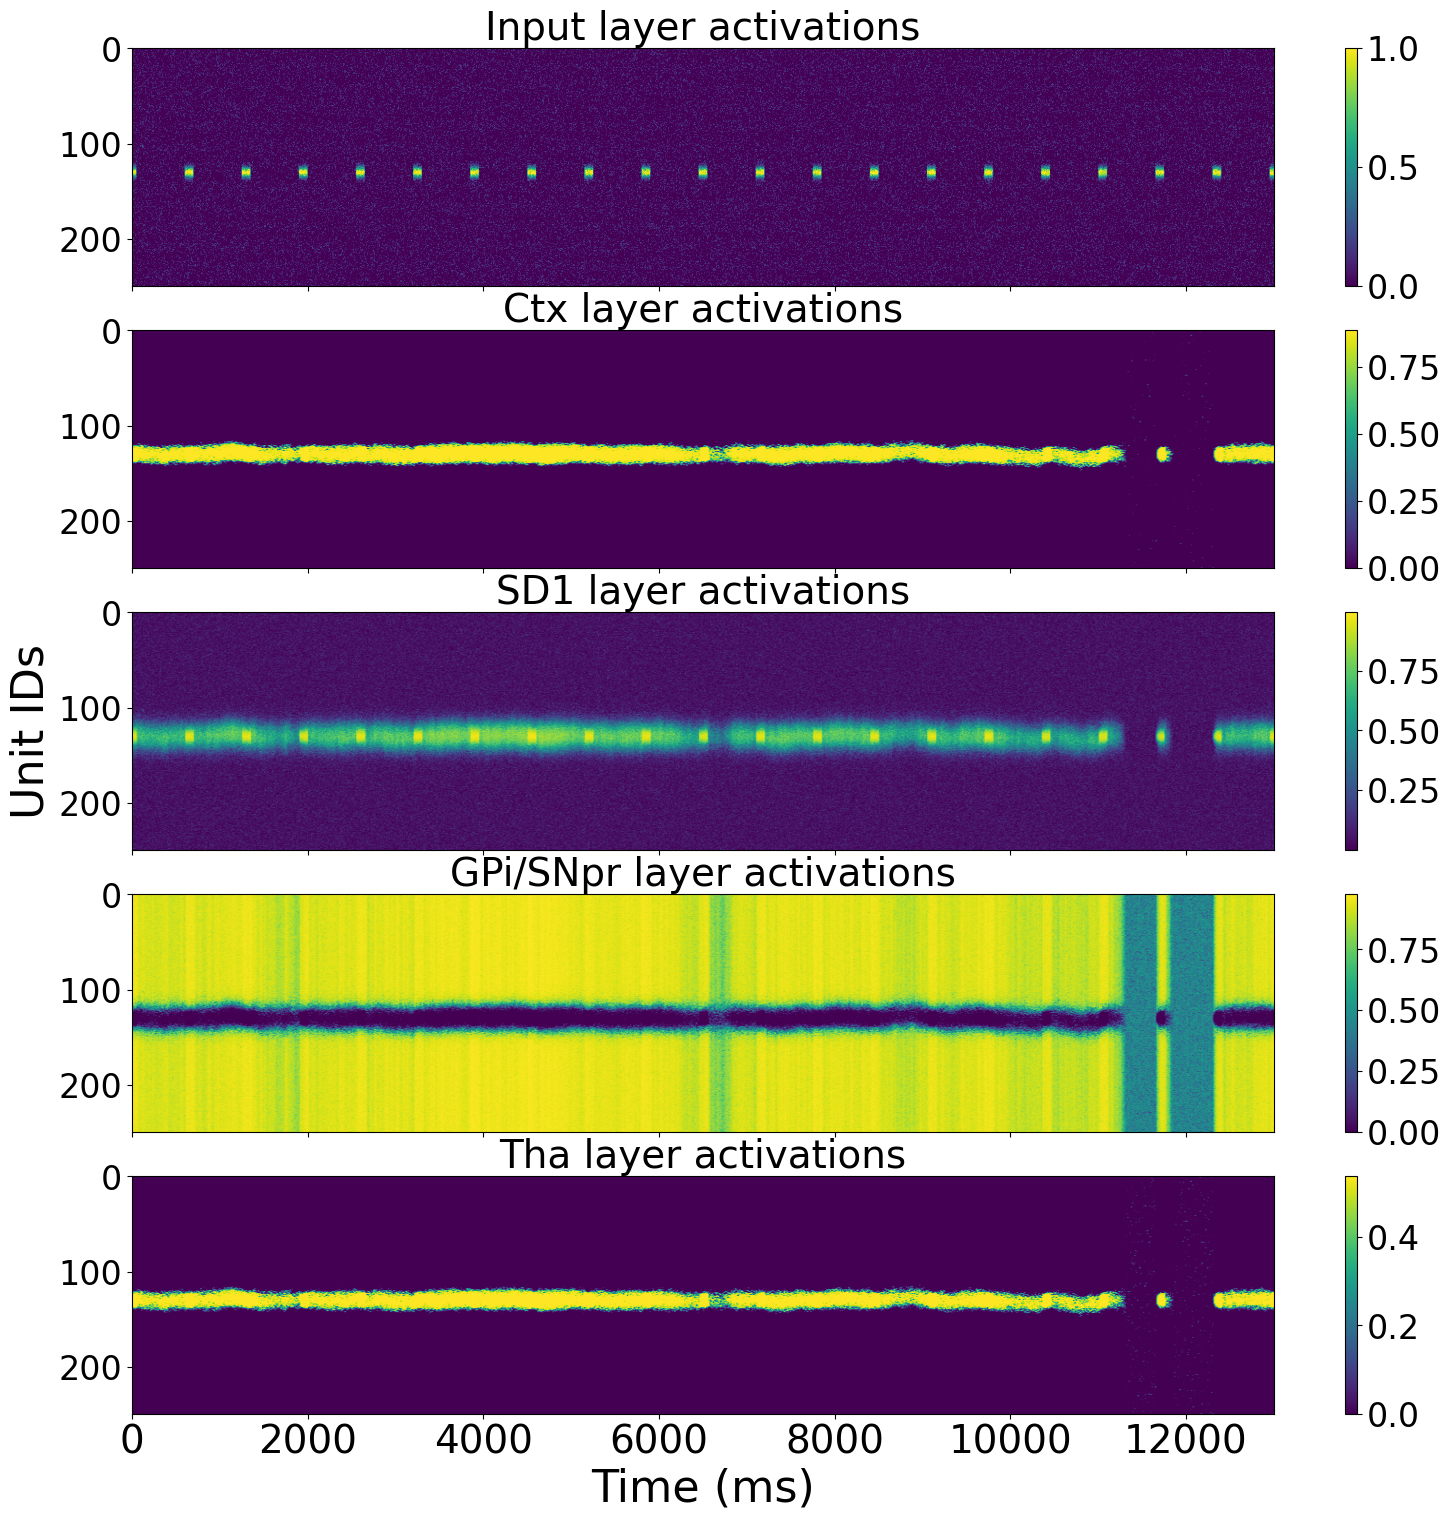

<Figure size 640x480 with 0 Axes>

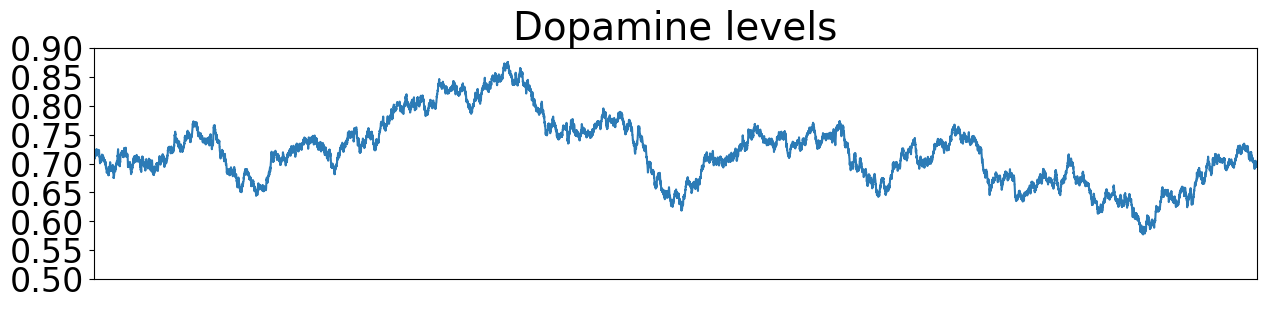

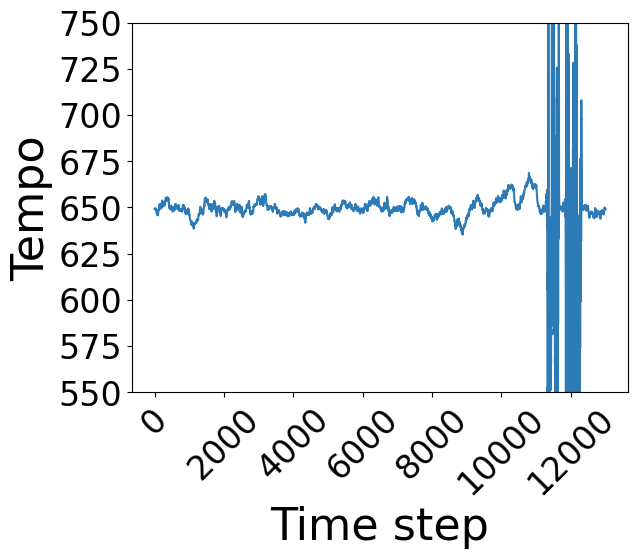

In [11]:
n_loops=250 #for notes on intializing the network see code for Figure 2a.
start_tempo=650
input_spread = 4
input = np.zeros((15000, n_loops))

bg1 = b_ganglia(n_loops=n_loops, time_steps=len(input), exc_spread = 10)

input[0:2000] = (stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread) / np.max(stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread)))

bg1.run(input,dop_level=np.ones(len(input))*0.7, da_noise = 0.075, input_noise_level = .01, ran_seed=12345678, RAS=650)

bg1.condensed_display()

# Fig 4c RAS Noise Breakdown

In [57]:
#repeat the same as above, but for trials with or without RAS.
RAS_var = np.zeros(n_trials)
nRAS_var = np.zeros(n_trials)

RAS_motor = np.zeros(n_trials)
nRAS_motor = np.zeros(n_trials)

RAS_drift = np.zeros(n_trials)
nRAS_drift = np.zeros(n_trials)

RAS_clock = np.zeros(n_trials)
nRAS_clock = np.zeros(n_trials)
for i in range(n_trials):
    ITIs  = nRAS_ITIS[i,:]
    n_taps = len(ITIs)
    s0 = (1/(n_taps-1)) * np.sum((ITIs - np.mean(ITIs))**2)

    s1 = (1/(2*(n_taps-1))) * np.sum(np.diff(ITIs)**2)

    s2 = (1/(2*(n_taps-2))) * (np.sum((ITIs[2:] - ITIs[0:-2])**2))

    nRAS_clock[i] = 3*s2 - 2*s1
    nRAS_motor[i] = s1-s2
    nRAS_drift[i] = s0 - 2*s1/n_taps - s2*(n_taps-1)/n_taps

    nRAS_var[i] = s0
    
    ITIs  = RAS_ITIS[i,:]
    n_taps = len(ITIs)
    s0 = (1/(n_taps-1)) * np.sum((ITIs - np.mean(ITIs))**2)
    s1 = (1/(2*(n_taps-1))) * np.sum(np.diff(ITIs)**2)

    s2 = (1/(2*(n_taps-2))) * (np.sum((ITIs[2:] - ITIs[0:-2])**2))

    RAS_clock[i] = 3*s2 - 2*s1
    RAS_motor[i] = s1-s2
    RAS_drift[i] = s0 - 2*s1/n_taps - s2*(n_taps-1)/n_taps

    RAS_var[i] = s0

 
results = stats.mannwhitneyu(RAS_motor,nRAS_motor)
print('p = ' + str(results[1]))

p = 0.9192324293875613


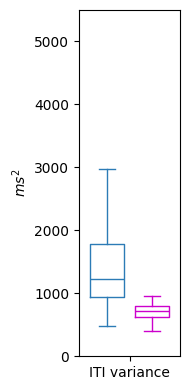

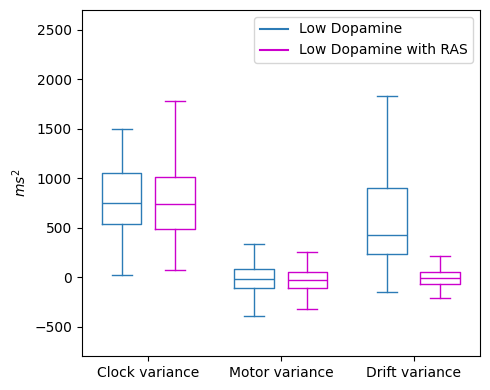

In [58]:

data_a = [nRAS_clock, nRAS_motor, nRAS_drift]
data_b = [RAS_clock, RAS_motor, RAS_drift]

plt.figure(figsize=(2,4))

bpl = plt.boxplot(nRAS_var, positions=[-.4], sym='', widths=0.6)
bpr = plt.boxplot(RAS_var, positions=[0.4], sym='', widths=0.6)
set_box_color(bpl, '#2C7BB6') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#CC00CC')

plt.plot([], c='#2C7BB6', label='Low dopamine, no RAS')
plt.plot([], c='#CC00CC', label='Low dopamine, RAS')
#plt.legend(loc = 'upper center')

plt.xticks([0],['ITI variance'])
plt.ylim(0, 5500)
plt.ylabel(r'$ms^2$')
plt.tight_layout()
plt.savefig('RAS_varcompare_data.png')

plt.figure(figsize=(5,4))

bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#2C7BB6') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#CC00CC')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#2C7BB6', label='Low Dopamine')
plt.plot([], c='#CC00CC', label='Low Dopamine with RAS')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-1, len(ticks)*2-1)
plt.ylim(-800, 2700)
plt.ylabel(r'$ms^2$')
#plt.ylim(0, 8)
plt.tight_layout()
plt.savefig('RAS_subvarcompare_data.png')


In [59]:
#f = open("PD_AHC_data.pkl", "wb")
#pickle.dump(ITI_data, f)
#f.close()

# Fig 4d Effect of RAS on Tempo Trace

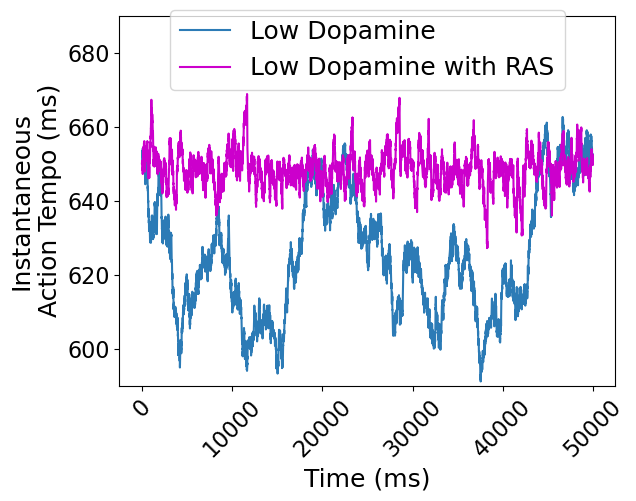

In [13]:
n_loops=250 #for notes on intializing the network see code for Figure 2a.
start_tempo=650
input_spread = 4
input = np.zeros((52000, n_loops))

input[0:2000] = (stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread) / np.max(stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread)))

#intialize and run a network with RAS
bg1 = b_ganglia(n_loops=n_loops, time_steps=len(input), exc_spread = 10)
bg1.run(input,dop_level=np.ones(len(input))*0.7, da_noise = 0, input_noise_level = 0.01, RAS=650, ran_seed=1234568)

#intialize and run a network without RAS
bg2 = b_ganglia(n_loops=n_loops, time_steps=len(input), exc_spread = 10)
bg2.run(input,dop_level=np.ones(len(input)) * 0.7, da_noise = 0, input_noise_level = .01, ran_seed=1234568)

plt.figure()
plt.plot(bg2.tempo_report[2000:], label = 'Low Dopamine', c='#2C7BB6')
plt.plot(bg1.tempo_report[2000:],label = 'Low Dopamine with RAS', c='#CC00CC')

plt.ylabel("Instantaneous\nAction Tempo (ms)", fontsize=18)
plt.xlabel("Time (ms)", fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16,rotation=45)
plt.ylim(590,690)

plt.legend(fontsize=18, bbox_to_anchor=(0.5, 1.05), loc='upper center')

# Fig 5a/b Visualizing effect of RAS shift on network activity.

In [19]:
n_loops=250
start_tempo=650
input_spread = 4
input = np.zeros((15000, n_loops))

bg1 = b_ganglia(n_loops=n_loops, time_steps=len(input), exc_spread = 10)

input[0:2000] = stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread) / np.max(stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread))

bg1.run(input,dop_level=np.ones(len(input)), da_noise = 0, input_noise_level = 0, RAS = 650, tempo_switch=50, RAS_spread = 4, RAS_strength = 1)


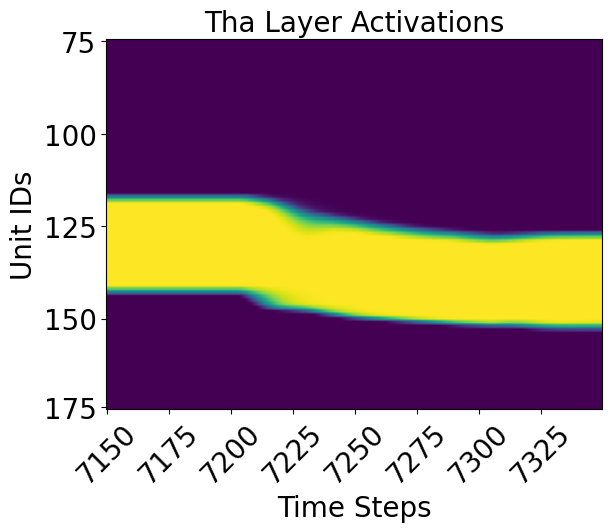

<Figure size 640x480 with 0 Axes>

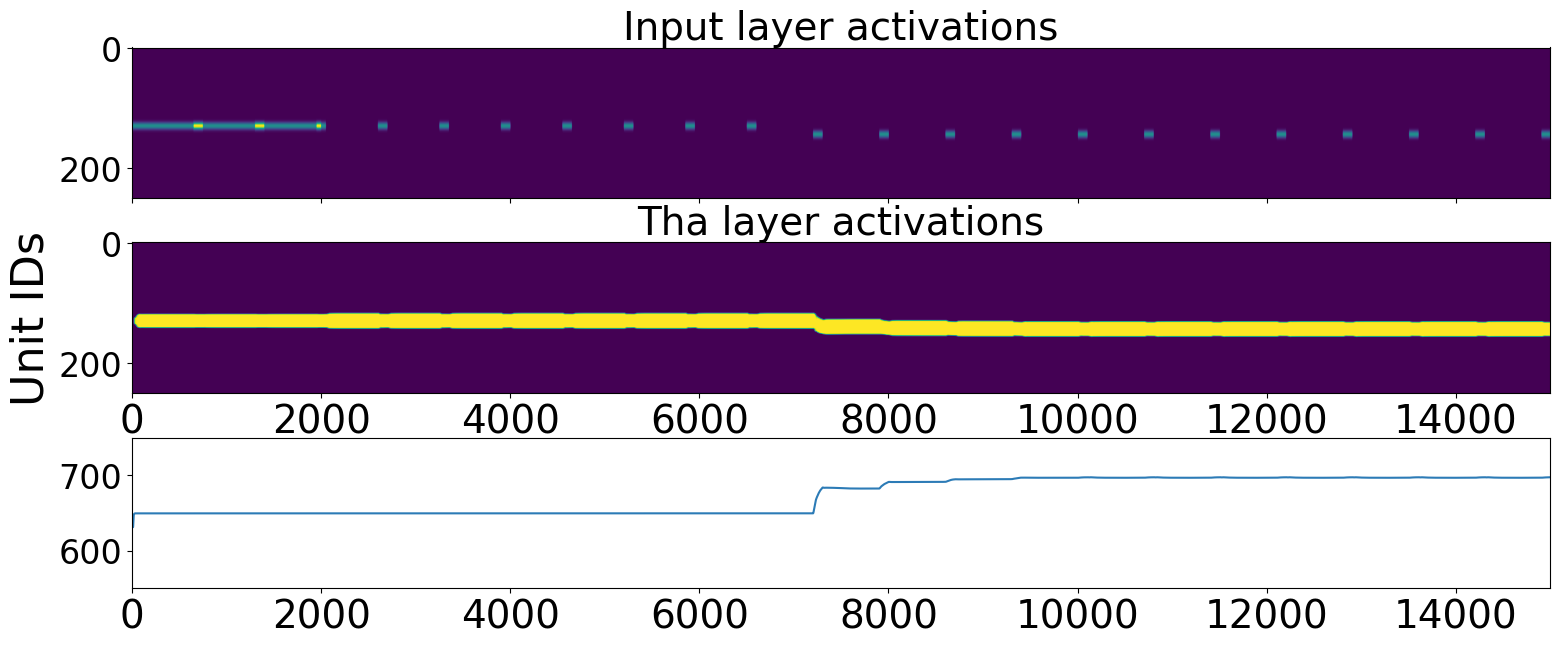

In [124]:

plt.imshow(bg1.a_tha[7150:7350,75:175].T,aspect='auto')
plt.title('Tha Layer Activations', fontsize=20)
plt.ylabel('Unit IDs', fontsize= 20)
plt.xlabel('Time Steps', fontsize= 20)
plt.yticks([0, 25, 50, 75, 99],['75', '100', '125', '150', '175'],fontsize=20)
plt.xticks([0,25,50,75,100,125,150,175], ['7150','7175','7200','7225','7250','7275','7300','7325'],fontsize=20,rotation=45)

plt.figure()
bg1.mini_display()

In [20]:
n_loops=250
start_tempo=650
input_spread = 4
input = np.zeros((15000, n_loops))

bg2 = b_ganglia(n_loops=n_loops, time_steps=len(input), exc_spread = 10)

input[0:2000] = stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread) / np.max(stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread))

bg2.run(input,dop_level=np.ones(len(input))*0.7, da_noise = 0, input_noise_level = 0, RAS = 650, RAS_spread = 4, RAS_strength = 1, tempo_switch=50)


([<matplotlib.axis.XTick at 0x21b5c1480b0>,
 [Text(0, 0, '7150'),
  Text(25, 0, '7175'),
  Text(50, 0, '7200'),
  Text(75, 0, '7225'),
  Text(100, 0, '7250'),
  Text(125, 0, '7275'),
  Text(150, 0, '7300'),
  Text(175, 0, '7325')])

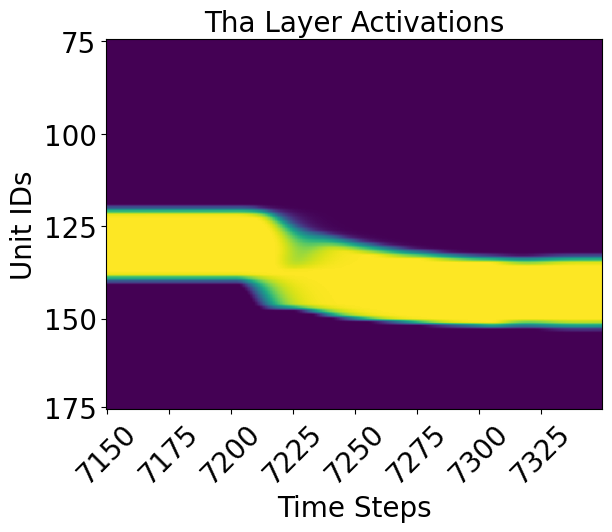

In [127]:

plt.imshow(bg2.a_tha[7150:7350,75:175].T,aspect='auto')
plt.title('Tha Layer Activations', fontsize=20)
plt.ylabel('Unit IDs', fontsize= 20)
plt.xlabel('Time Steps', fontsize= 20)
plt.yticks([0, 25, 50, 75, 99],['75', '100', '125', '150', '175'],fontsize=20)
plt.xticks([0,25,50,75,100,125,150,175], ['7150','7175','7200','7225','7250','7275','7300','7325'],fontsize=20,rotation=45)

(array([640., 650., 660., 670., 680., 690., 700.]),
 [Text(0, 640.0, '640'),
  Text(0, 650.0, '650'),
  Text(0, 660.0, '660'),
  Text(0, 670.0, '670'),
  Text(0, 680.0, '680'),
  Text(0, 690.0, '690'),
  Text(0, 700.0, '700')])

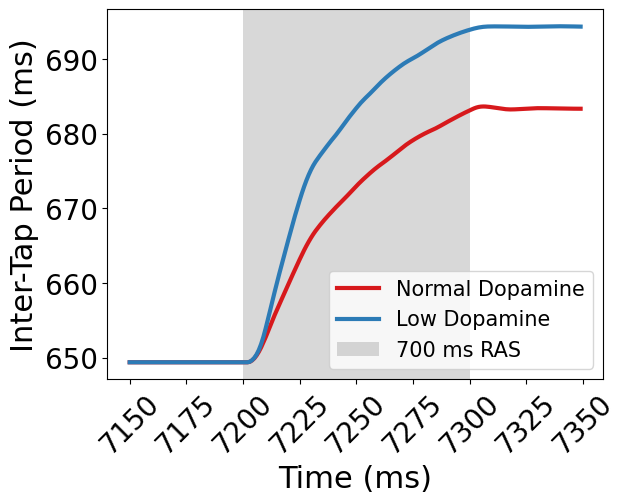

In [21]:
#plot the above network dynamics as a line graph showing the "selected" tempo.
plt.plot(bg1.tempo_report[7150:7350], label = "Normal Dopamine",linewidth=3, color='#D7191C')
plt.plot(bg2.tempo_report[7150:7350], label = "Low Dopamine",linewidth=3, c='#2C7BB6')
plt.axvspan(50, 150, facecolor='gray', alpha=0.3, label = "700 ms RAS")
plt.legend(fontsize=15, loc='lower right')
plt.ylabel("Inter-Tap Period (ms)", fontsize= 22)
plt.xlabel("Time (ms)", fontsize= 22)
plt.xticks([0,25,50,75,100,125,150,175,200], ['7150','7175','7200','7225','7250','7275','7300','7325','7350'],fontsize=20,rotation=45)
plt.yticks(fontsize=20)

# Fig 5c Effect of Dopamine on Bump Suggestability

In [17]:
n_loops=250 #for notes on intializing the network see code for Figure 2a.
start_tempo=650
input_spread = 4
input = np.zeros((15000, n_loops))

bg1 = b_ganglia(n_loops=n_loops, time_steps=len(input), exc_spread = 10)

input[0:2000] =  stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread) / np.max(stats.norm.pdf(bg1.unit_ids, bg1.tempo_to_index(start_tempo), input_spread))

#create arrays to hold results
tempo_store1 = np.zeros((2,len(input)-1))
ITI_store1 = np.zeros((2,21)) 
#define the dopamine values to be simulated over
dopes = [1,0.7]

#simulate at each dopamine value and store results. 
for i in range(2):
    bg1.run(input,dop_level=np.ones(len(input))*dopes[i], da_noise = 0, input_noise_level = 0, RAS = 650, RAS_spread = 4, RAS_strength = 1, tempo_switch=50)
    tempo_store1[i,:] = bg1.tempo_report
    ITI_store1[i,:] = bg1.ITI_report

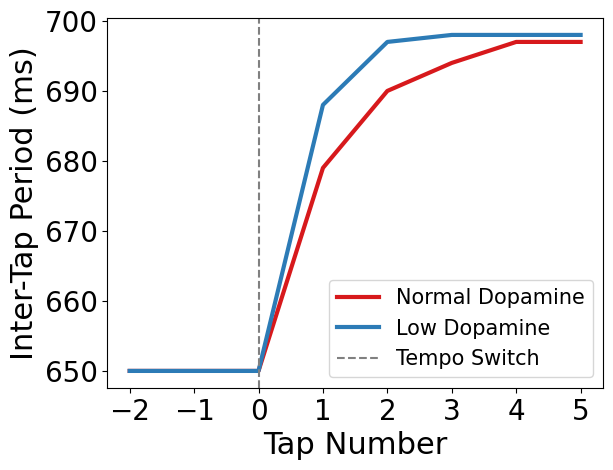

In [18]:
#plot results
x_ticks = np.arange(-2, 6)
plt.plot(x_ticks,ITI_store1[0,7:15], label = "Normal Dopamine",linewidth=3,color="#D7191C")
plt.plot(x_ticks,ITI_store1[1,7:15], label = "Low Dopamine",linewidth=3,color='#2C7BB6')
plt.axvline(x = 0, color = 'gray', label = 'Tempo Switch', ls="--")
plt.ylabel("Inter-Tap Period (ms)", fontsize=22)
plt.xlabel("Tap Number", fontsize=22)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=15)